<a href="https://colab.research.google.com/github/ykkim77/nlp-9th/blob/main/nlp_9th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tqdm import tqdm


In [89]:
def generate_timeseries(n_steps=50):
    m_x = np.random.uniform(0,10)
    xs = np.linspace(0, 5,n_steps+1)
    ys = np.array([0.5*np.sin(2*np.pi*(x+m_x))+np.cos(3*np.pi/2*(x+m_x/4))
                    +np.random.uniform(-0.1,0.1) for x in xs])
    return ys[:-1],ys[-1]

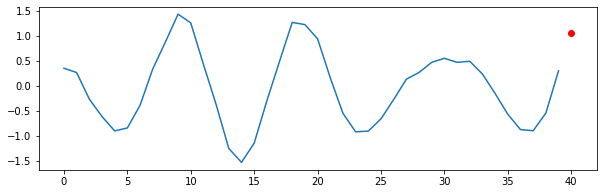

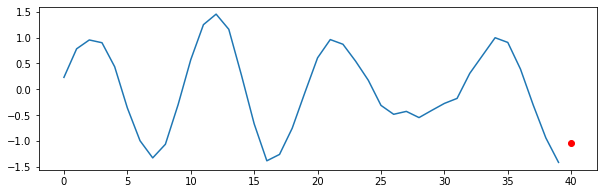

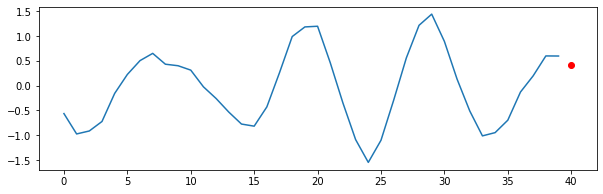

In [90]:
for __ in range(3):
    xs, ys = generate_timeseries(n_steps=40)
    timesteps = np.arange(len(xs)+1)
    plt.figure(figsize=(10,3))
    plt.plot(timesteps[:-1],xs)
    plt.scatter(timesteps[-1],ys,c='r')
    plt.show()

In [91]:
xs , ys = generate_timeseries()
ys

-0.1820785735285911

In [92]:
from tensorflow.keras.layers import SimpleRNN, Dense, Input, SimpleRNN
from tensorflow.keras.models import Model

In [94]:
n_neurons = 200
n_inputs = 1
n_steps = 30

input = Input(shape=(n_steps, n_inputs))
hidden = SimpleRNN(n_neurons,recurrent_initializer=tf.initializers.random_normal(0,1))(input)
output = Dense(1)(hidden)
model = Model(input,output)

model.compile(loss='mse', optimizer='adam')

In [103]:
def timestep_generator(n_steps=30, batch_size=30):
    while True:
        batch_xs, batch_ys = [],[]
        for __ in range(batch_size):
            x, y = generate_timeseries(n_steps)
            batch_xs.append(x[:,np.newaxis])
            batch_ys.append(y[np.newaxis])
        yield np.stack(batch_xs), np.stack(batch_ys)

train_gen = timestep_generator()
xs, ys = next(train_gen)
xs.shape, ys.shape

((30, 30, 1), (30, 1))

In [96]:
model.fit_generator(train_gen,steps_per_epoch=100,epochs=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 5s 37ms/step - loss: nan


In [97]:
# gradient clipping

import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
K.clear_session()

threshold = 1

n_neurons = 200
n_inputs = 1
n_steps = 30

input = Input(shape=(n_steps, n_inputs))
hidden = SimpleRNN(n_neurons,recurrent_initializer=tf.initializers.random_normal(0,1))(input)
output = Dense(1)(hidden)
model = Model(input,output)


model.compile(loss='mse', optimizer=Adam(clipnorm=0.1))

In [98]:
train_gen = timestep_generator()
model.fit_generator(train_gen,steps_per_epoch=100,epochs=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 5s 37ms/step - loss: 2.2775


**LSTM**

In [99]:
 from keras import Input
 from keras.layers import Layer, RNN
 from keras.models import Model
 import keras.backend as K

class CustomLSTMCell(Layer):

    def __init__(self, units, **kwargs):
        self.state_size = [units, units]
        super(CustomLSTMCell, self).__init__(**kwargs)

    def build(self, input_shape):

        self.forget_w = self.add_weight(shape=(1, self.state_size[0], self.state_size[0] + input_shape[-1]),
                                         initializer='uniform',
                                         name='forget_w')
        self.forget_b = self.add_weight(shape=(1, self.state_size[0]),
                                         initializer='uniform',
                                         name='forget_b')

        self.input_w1 = self.add_weight(shape=(1, self.state_size[0], self.state_size[0] + input_shape[-1]),
                                         initializer='uniform',
                                         name='input_w1')
        self.input_b1 = self.add_weight(shape=(1, self.state_size[0]),
                                         initializer='uniform',
                                         name='input_b1')
        self.input_w2 = self.add_weight(shape=(1, self.state_size[0], self.state_size[0] + input_shape[-1]),
                                         initializer='uniform',
                                         name='input_w2')
        self.input_b2 = self.add_weight(shape=(1, self.state_size[0],),
                                         initializer='uniform',
                                         name='input_b2')

        self.output_w = self.add_weight(shape=(1, self.state_size[0], self.state_size[0] + input_shape[-1]),
                                         initializer='uniform',
                                         name='output_w')
        self.output_b = self.add_weight(shape=(1, self.state_size[0],),
                                        initializer='uniform',
                                         name='output_b')

        self.built = True


    def merge_with_state(self, inputs):
         self.stateH = K.concatenate([self.stateH, inputs], axis=-1)

    def forget_gate(self):        
         forget = K.batch_dot(self.forget_w, self.stateH) + self.forget_b
         forget = K.sigmoid(forget)
         self.stateC = self.stateC * forget

    def input_gate(self):
         candidate = K.batch_dot(self.input_w1, self.stateH) + self.input_b1
         candidate = K.tanh(candidate)

         amount = K.batch_dot(self.input_w2, self.stateH) + self.input_b2
         amount = K.sigmoid(amount)

         self.stateC = self.stateC + amount * candidate

    def output_gate(self):
         self.stateH = K.batch_dot(self.output_w, self.stateH) + self.output_b
         self.stateH = K.sigmoid(self.stateH)

         self.stateH = self.stateH * K.tanh(self.stateC)

    def call(self, inputs, states):

         self.stateH = states[0]
         self.stateC = states[1]

         self.merge_with_state(inputs)
         self.forget_gate()
         self.input_gate()
         self.output_gate()

         return self.stateH, [self.stateH, self.stateC]

In [100]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RNN


K.clear_session()


n_neurons = 200
n_inputs = 1
n_steps = 30

input = Input(shape=(n_steps, n_inputs))
hidden = RNN(CustomLSTMCell(100))(input)
output = Dense(1)(hidden)
model = Model(input,output)

#gradient clipping
model.compile(loss='mse', optimizer=Adam(clipnorm=0.1))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
rnn (RNN)                    (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [104]:
train_gen = timestep_generator()
model.fit_generator(train_gen,steps_per_epoch=100, epochs=1)

  1/100 [..............................] - ETA: 8s - loss: 0.2774

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 9s 87ms/step - loss: 0.1006


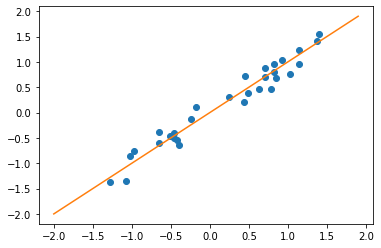

In [106]:
xs, ys = next(train_gen)
xs.shape
pred = model.predict(xs)

#visuallization

import matplotlib.pyplot as plt

plt.scatter(pred,ys)
plt.plot(np.arange(-2,2,0.1), np.arange(-2,2,0.1), c ='C1')